In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
### Set Pandas display format
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 1000)

### Read data

In [3]:
# Read data
orders_cl = pd.read_csv('data/orders_cl.csv')
orderlines_cl = pd.read_csv('data/orderlines_cl.csv')
products_cl = pd.read_csv('data/products_cl.csv')

# Copy the dataframes for analysis
orders_cl_copy = orders_cl.copy()
orderlines_cl_copy = orderlines_cl.copy()
products_cl_copy = products_cl.copy()

### Remove unwanted orders
We will only take into consideration the orders that are delivered

In [4]:
orders_cl_copy = orders_cl_copy.loc[orders_cl_copy['state'].isin(['Completed']), :]

In [5]:
orders_orderlines_combined = orderlines_cl_copy.merge(orders_cl_copy, left_on='id_order', right_on='order_id', how='inner').copy()
# orders_orderlines_combined.info()

#### Remove orders with unknown products

In [6]:
problematic_order_ids = orders_orderlines_combined.loc[~orders_orderlines_combined['sku'].isin(products_cl['sku']), 'order_id']
# print(problematic_order_ids)  # total 1394 ids
# problematic_order_ids.unique().shape  # 1363 unique ids

In [7]:
orders_orderlines_combined_cleaned = orders_orderlines_combined.loc[~orders_orderlines_combined['order_id'].isin(problematic_order_ids.unique()), :]
# orders_orderlines_combined_cleaned.info()

### Explore revenue

In [8]:
# Compute total price per line
orders_orderlines_combined_cleaned['unit_price_total'] = orders_orderlines_combined_cleaned['unit_price']*orders_orderlines_combined_cleaned['product_quantity']

C:\Users\rajun\AppData\Local\Temp\ipykernel_108\1394380008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_orderlines_combined_cleaned['unit_price_total'] = orders_orderlines_combined_cleaned['unit_price']*orders_orderlines_combined_cleaned['product_quantity']


#### Compute the total order price based on `unit_price_total`

In [9]:
# your code here
orderlines_order_ids = orders_orderlines_combined_cleaned.groupby('id_order', as_index=False).sum()[['id_order', "unit_price_total"]]
# orderlines_order_ids

#### What is the average difference between `total_paid` and `unit_price_total`?

In [10]:
diff_df = orders_cl_copy.merge(orderlines_order_ids, left_on="order_id", right_on="id_order")

# Check the difference between total_paid and unit_price_total
diff_df["difference"] = diff_df["total_paid"] - diff_df["unit_price_total"]
diff_df.head(10)

,order_id,created_date,total_paid,state,id_order,unit_price_total,difference
0,241423,2017-11-06 13:10:02,136.15,Completed,241423,129.16,6.99
1,242832,2017-12-31 17:40:03,15.76,Completed,242832,10.77,4.99
2,243330,2017-02-16 10:59:38,84.98,Completed,243330,77.99,6.99
3,245275,2017-06-28 11:35:37,149.00,Completed,245275,149.00,0.00
4,245595,2017-01-21 12:52:47,112.97,Completed,245595,105.98,6.99
5,246405,2017-11-24 10:01:27,407.96,Completed,246405,275.75,132.21
6,247524,2018-01-09 14:21:34,167.98,Completed,247524,162.99,4.99
7,247643,2017-05-26 11:50:35,153.54,Completed,247643,153.54,0.00
8,250275,2017-11-19 22:34:54,54.99,Completed,250275,51.00,3.99
9,251302,2017-05-10 12:27:33,140.99,Completed,251302,140.99,0.00


In [11]:
diff_df.difference.describe()

count   41701.00
mean        4.47
std        26.05
min      -165.00
25%         0.00
50%         4.99
75%         6.99
max      3984.99
Name: difference, dtype: float64

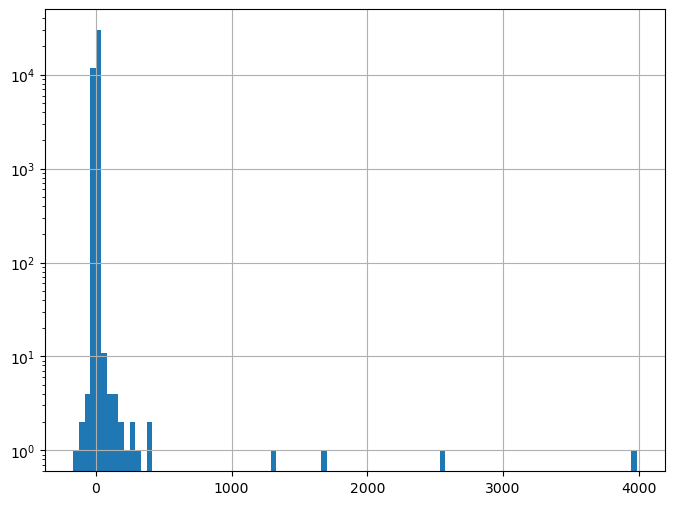

In [12]:
# Distribution of the differences
diff_df.difference.hist(bins= 100, figsize=(8,6))
plt.yscale('log');

#### Analyze and remove orders with unexplainable differnces

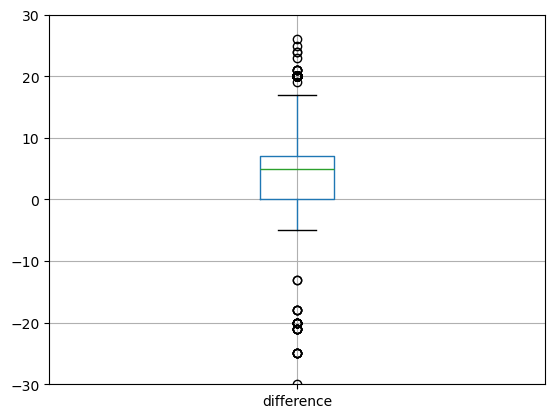

In [13]:
ax = diff_df.boxplot("difference");
ax.set_ylim(-30, +30)
plt.show()

In [14]:
# Calculate the quartiles and IQR
Q1 = diff_df["difference"].quantile(0.25)
Q3 = diff_df["difference"].quantile(0.75)

IQR = Q3-Q1
print(f"Q1: {Q1} \t Q3: {Q3} \t IQR: {IQR}")

Q1: 0.0 	 Q3: 6.989999999999981 	 IQR: 6.989999999999981


In [15]:
# lower boundary   Q1 - 1.5*IQR         # upper boundary   Q3 + 1.5*IQR
# filter the DataFrame to include only "non-outliers"
diff_no_outliers_df = diff_df[(diff_df["difference"] >= (Q1 - 1.5*IQR))&(diff_df["difference"] <= (Q3 + 1.5*IQR))]
diff_no_outliers_df.shape

(40985, 7)

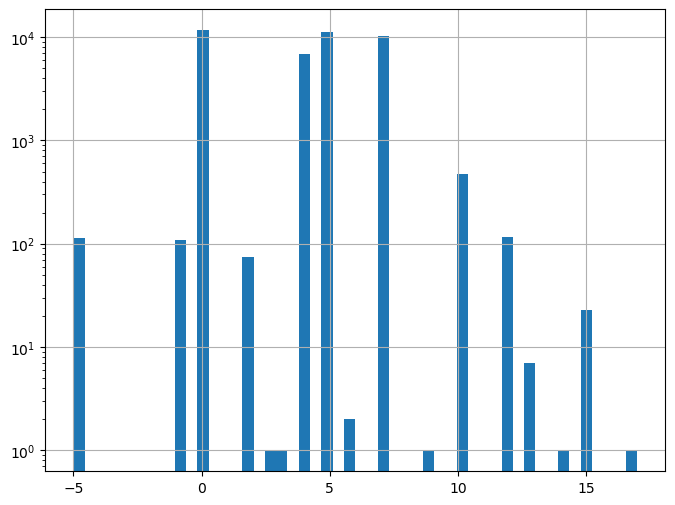

In [16]:
# Check the difference distribution again
diff_no_outliers_df.difference.hist(bins= 50, figsize=(8,6))
plt.yscale('log');

<Axes: >

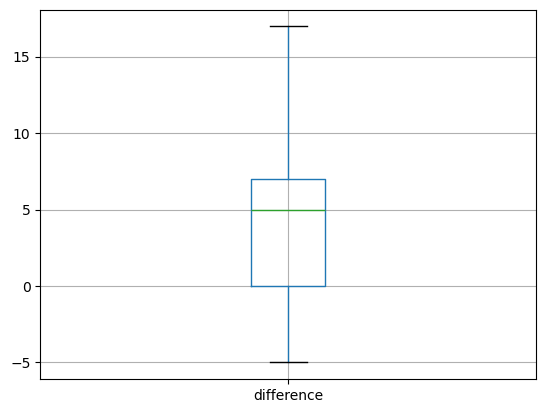

In [17]:
diff_no_outliers_df.boxplot("difference")

In [18]:
normal_diff_list = diff_no_outliers_df["order_id"]
normal_diff_list.shape

(40985,)

In [19]:
orders_qu = orders_cl_copy.loc[orders_cl_copy["order_id"].isin(normal_diff_list), :]
orderlines_qu = orderlines_cl_copy.loc[orderlines_cl_copy["id_order"].isin(normal_diff_list), :]

orders_qu["order_id"].nunique(), orderlines_qu["id_order"].nunique()

(40985, 40985)

### Price Analysis

In [20]:
# Compute total price per line for the filtered orders
orderlines_qu['unit_price_total'] = orderlines_qu['unit_price'] * orderlines_qu['product_quantity']

C:\Users\rajun\AppData\Local\Temp\ipykernel_108\4285860838.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orderlines_qu['unit_price_total'] = orderlines_qu['unit_price'] * orderlines_qu['product_quantity']


In [21]:
# Create a list of products based on the revenue they generated
prod_list_revenue = orderlines_qu.groupby('sku').agg({'unit_price_total': 'sum'}).sort_values('unit_price_total', ascending=False) #.sort_values(by='unit_price_total', ascending=False)
# prod_list_revenue

##### Add product info to the orderlines

In [22]:
orderlines_products_qu = orderlines_qu.merge(products_cl, on='sku', how='left')
orderlines_products_qu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53231 entries, 0 to 53230
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                53231 non-null  int64  
 1   id_order          53231 non-null  int64  
 2   product_id        53231 non-null  int64  
 3   product_quantity  53231 non-null  int64  
 4   sku               53231 non-null  object 
 5   unit_price        53231 non-null  float64
 6   date              53231 non-null  object 
 7   unit_price_total  53231 non-null  float64
 8   name              53231 non-null  object 
 9   desc              53231 non-null  object 
 10  price             53231 non-null  float64
 11  in_stock          53231 non-null  int64  
 12  type              53220 non-null  object 
dtypes: float64(3), int64(5), object(5)
memory usage: 5.3+ MB


### Discount Analysis

In [23]:
orderlines_products_qu['discount'] = 100*(orderlines_products_qu['price'] - orderlines_products_qu['unit_price'])/orderlines_products_qu['price']

# Categorize products based on whether they had a discount or not
orderlines_products_qu['discount_category'] = 'no discount'
orderlines_products_qu.loc[orderlines_products_qu['discount'] > 0, 'discount_category'] = 'discount'

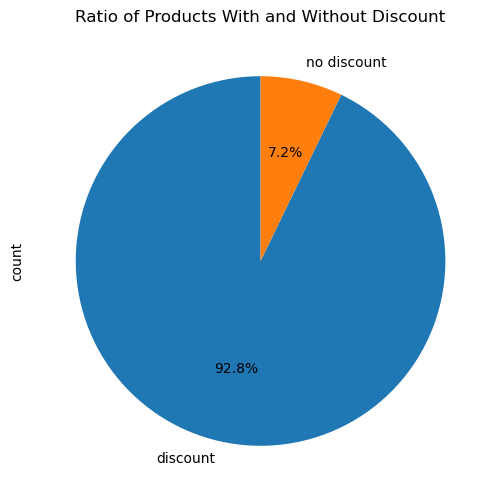

In [24]:
orderlines_products_qu['discount_category'].value_counts().plot(kind='pie', figsize=(6,6), title='Ratio of Products With and Without Discount', autopct='%1.1f%%', startangle=90);

##### Get top and bottom 5 revenue generating products

In [25]:
n = 5
top_revenue_df = orderlines_products_qu.loc[orderlines_products_qu['sku'].isin(prod_list_revenue.index[:n]), ['sku', 'discount']] .groupby('sku').agg({'discount': 'mean'}).sort_index() #.plot.bar();
top_revenue_df = top_revenue_df.reset_index()
top_revenue_df['sku'] = pd.Categorical(top_revenue_df['sku'], categories=prod_list_revenue.index[:n], ordered=True)

top_revenue_df_sorted = top_revenue_df.sort_values('sku')

In [26]:
bottom_revenue_df = orderlines_products_qu.loc[orderlines_products_qu['sku'].isin(prod_list_revenue.index[-n:]), ['sku', 'discount']] .groupby('sku').agg({'discount': 'mean'}).sort_index() #.plot.bar();
bottom_revenue_df = bottom_revenue_df.reset_index()
bottom_revenue_df['sku'] = pd.Categorical(bottom_revenue_df['sku'], categories=prod_list_revenue.index[-n:], ordered=True)

bottom_revenue_df_sorted = bottom_revenue_df.sort_values('sku')

In [27]:
print(f"Average discount for top {n} revenue generating items: {top_revenue_df_sorted['discount'].mean():.2f}")
print(f"Average discount for top {n} revenue generating items: {bottom_revenue_df_sorted['discount'].mean():.2f}")

Average discount for top 5 revenue generating items: 9.01
Average discount for top 5 revenue generating items: 55.30


In [28]:
# Combine top and bottom 5 revenue generating products 
top_revenue_df_sorted['category'] = 'high revenue'
bottom_revenue_df_sorted['category'] = 'low revenue'
data_list = [top_revenue_df_sorted, bottom_revenue_df_sorted]

top_and_bottom_revenue_products_df = pd.concat(data_list)
top_and_bottom_revenue_products_df = top_and_bottom_revenue_products_df.merge(products_cl_copy, on='sku', how='left')[['sku', 'name', 'discount', 'category']].copy()
# top_and_bottom_revenue_products_df

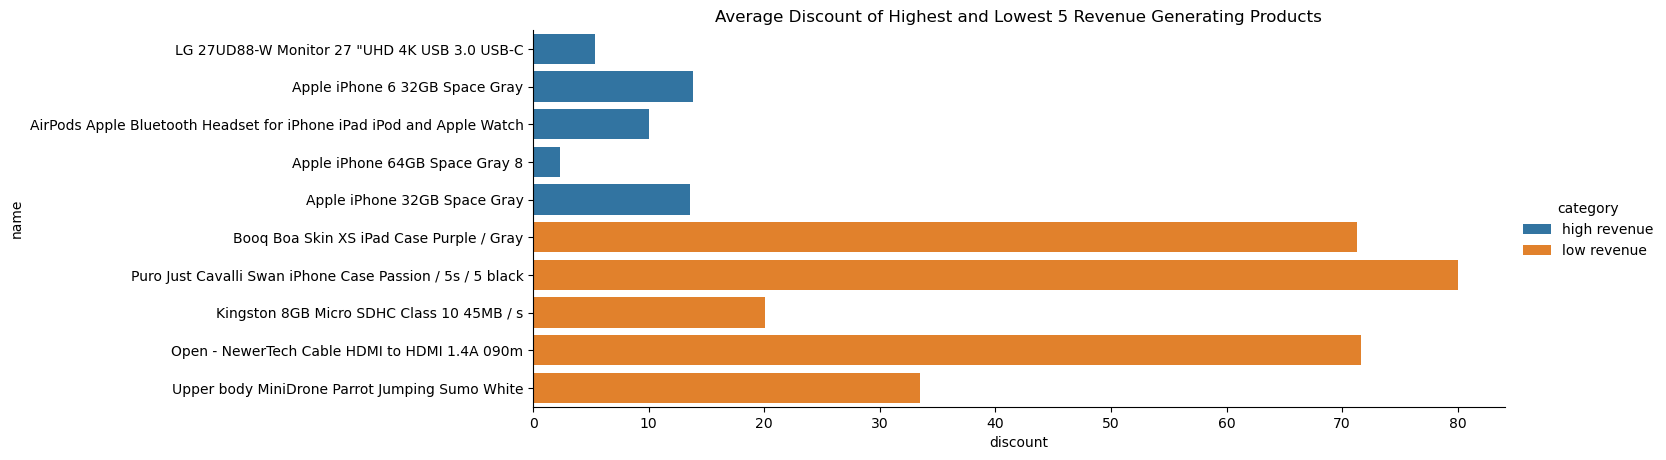

In [29]:
combined_plot = sns.catplot(top_and_bottom_revenue_products_df, kind='bar',
            x='discount', y='name', hue='category', aspect=3.5, height=4.5)
combined_plot.ax.set_title(f'Average Discount of Highest and Lowest {n} Revenue Generating Products');

#### Discount Variation Over Time
Here, we analyze the impact of discount on the sales and revenue of important products

In [30]:
# Fix the date format issues in both dataframes

orders_qu['created_date'] = pd.to_datetime(orders_qu['created_date'])
orderlines_products_qu['date'] = pd.to_datetime(orderlines_products_qu['date'])

C:\Users\rajun\AppData\Local\Temp\ipykernel_108\3598390833.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_qu['created_date'] = pd.to_datetime(orders_qu['created_date'])


In [31]:
# Create a year-month value for each entry
orders_qu['created_date_Y_m'] = orders_qu['created_date'].dt.strftime("%Y-%m")
orderlines_products_qu['date_Y_m'] = orderlines_products_qu['date'].dt.strftime("%Y-%m")

C:\Users\rajun\AppData\Local\Temp\ipykernel_108\823605937.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_qu['created_date_Y_m'] = orders_qu['created_date'].dt.strftime("%Y-%m")


##### Most revenue generating product

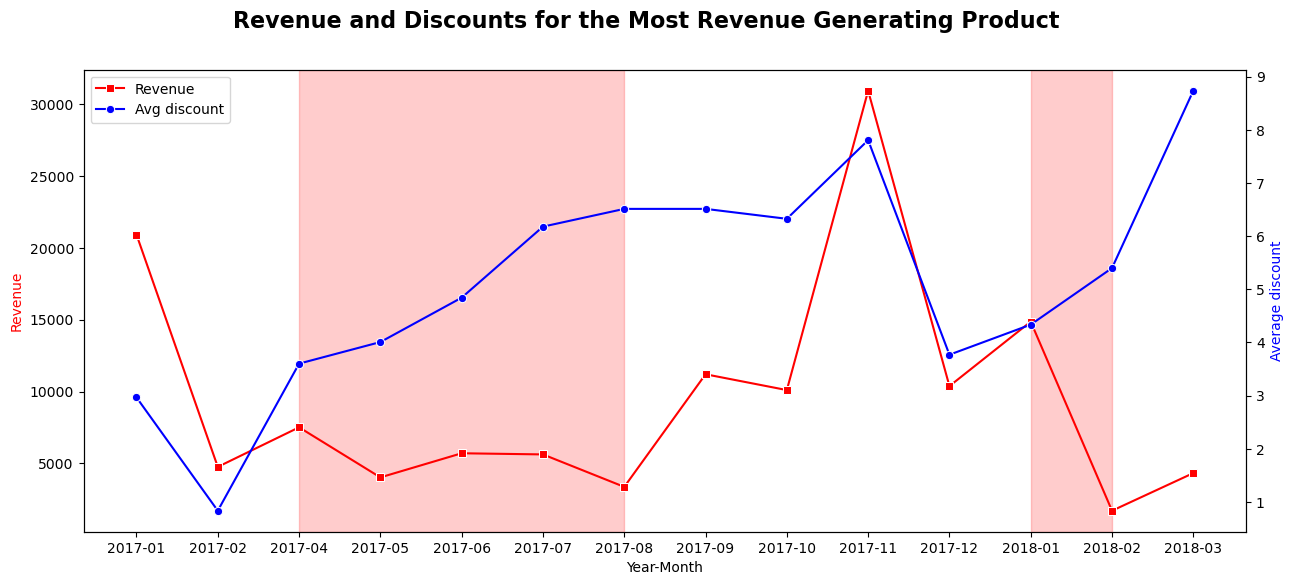

In [32]:
fig, ax1 = plt.subplots(figsize=(15,6))
ax1 = sns.lineplot(data=orderlines_products_qu[orderlines_products_qu['sku']==top_revenue_df_sorted.iloc[0].sku].groupby('date_Y_m')['unit_price_total'].sum(),
           color="red", label="Revenue", marker='s', legend=False)
ax1.set_ylabel("Revenue", color="red")
ax1.set_xlabel("Year-Month")
ax1.tick_params(axis="y")

ax2 = ax1.twinx()
ax2 = sns.lineplot(data=orderlines_products_qu[orderlines_products_qu['sku']==top_revenue_df_sorted.iloc[0].sku].groupby('date_Y_m')['discount'].mean(),
            color="blue", label="Avg discount", marker='o', legend=False)
ax2.set_ylabel("Average discount", color="blue")
ax2.set_xlabel("Year-Month")
ax2.tick_params(axis="y")

ax1.axvspan('2017-04', '2017-08', color="red", alpha=0.2)
ax1.axvspan('2018-01', '2018-02', color="red", alpha=0.2)
#ax2.axvspan('2017-04', '2017-07', color="blue", alpha=0.2)

# Merge legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

fig.suptitle("Revenue and Discounts for the Most Revenue Generating Product", fontsize=16, fontweight="bold")

plt.show()

##### Most sold product

In [33]:
prod_list_sales = orderlines_products_qu.groupby('sku', as_index=False).agg({'product_quantity': 'sum'}).sort_values('product_quantity', ascending=False) #.sort_values(by='unit_price_total', ascending=False)
# prod_list_sales

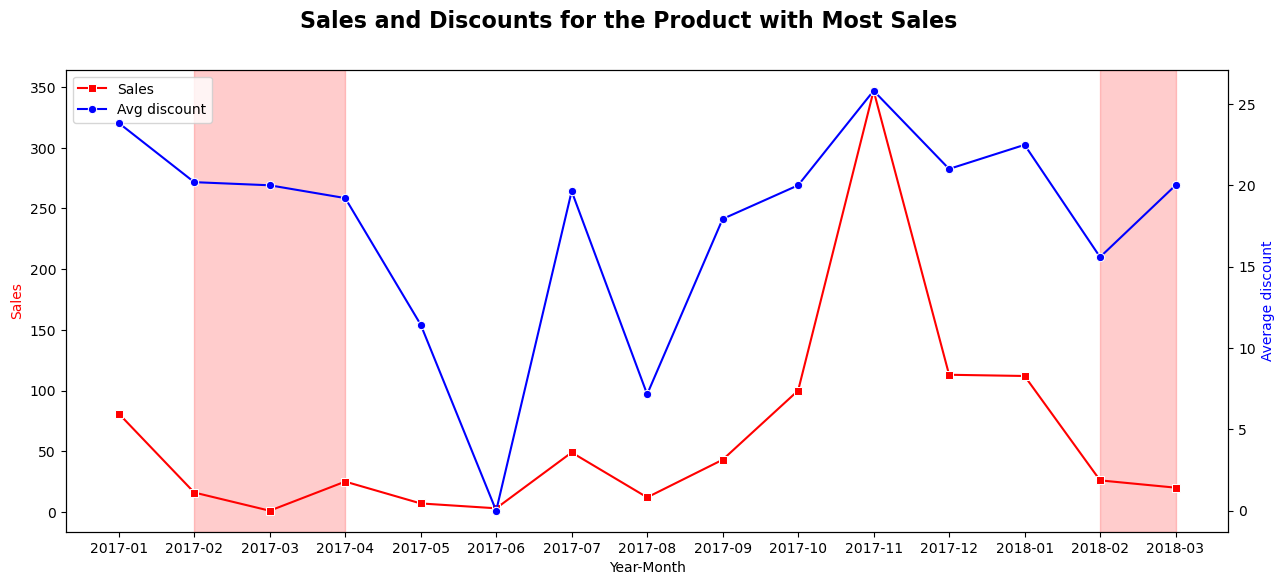

In [34]:
fig, ax1 = plt.subplots(figsize=(15,6))
ax1 = sns.lineplot(data=orderlines_products_qu[orderlines_products_qu['sku']==prod_list_sales.iloc[0].sku].groupby('date_Y_m')['product_quantity'].sum(),
           color="red", label="Sales", marker='s', legend=False)
ax1.set_ylabel("Sales", color="red")
ax1.tick_params(axis="y")
ax1.set_xlabel("Year-Month")

ax2 = ax1.twinx()
ax2 = sns.lineplot(data=orderlines_products_qu[orderlines_products_qu['sku']==prod_list_sales.iloc[0].sku].groupby('date_Y_m')['discount'].mean(),
            color="blue", label="Avg discount", marker='o', legend=False)
ax2.set_ylabel("Average discount", color="blue")
ax2.tick_params(axis="y")
ax2.set_xlabel("Year-Month")

ax1.axvspan('2017-02', '2017-04', color="red", alpha=0.2)
ax1.axvspan('2018-02', '2018-03', color="red", alpha=0.2)

# Merge legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

fig.suptitle("Sales and Discounts for the Product with Most Sales", fontsize=16, fontweight="bold")

plt.show()

### Product Categorization

In [35]:
orderlines_products_qu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53231 entries, 0 to 53230
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 53231 non-null  int64         
 1   id_order           53231 non-null  int64         
 2   product_id         53231 non-null  int64         
 3   product_quantity   53231 non-null  int64         
 4   sku                53231 non-null  object        
 5   unit_price         53231 non-null  float64       
 6   date               53231 non-null  datetime64[ns]
 7   unit_price_total   53231 non-null  float64       
 8   name               53231 non-null  object        
 9   desc               53231 non-null  object        
 10  price              53231 non-null  float64       
 11  in_stock           53231 non-null  int64         
 12  type               53220 non-null  object        
 13  discount           53231 non-null  float64       
 14  discou

#### Based on the amount of discount

In [36]:
# Create boolean values for discount categories
discount_90_100_per_bool = orderlines_products_qu['discount'] >= 90
discount_80_90_per_bool = (orderlines_products_qu['discount'] >= 80) & (orderlines_products_qu['discount'] < 90)
discount_70_80_per_bool = (orderlines_products_qu['discount'] >= 70) & (orderlines_products_qu['discount'] < 80)
discount_60_70_per_bool = (orderlines_products_qu['discount'] >= 60) & (orderlines_products_qu['discount'] < 70)
discount_50_60_per_bool = (orderlines_products_qu['discount'] >= 50) & (orderlines_products_qu['discount'] < 60)
discount_40_50_per_bool = (orderlines_products_qu['discount'] >= 40) & (orderlines_products_qu['discount'] < 50)
discount_30_40_per_bool = (orderlines_products_qu['discount'] >= 30) & (orderlines_products_qu['discount'] < 40)
discount_20_30_per_bool = (orderlines_products_qu['discount'] >= 20) & (orderlines_products_qu['discount'] < 30)
discount_10_20_per_bool = (orderlines_products_qu['discount'] >= 10) & (orderlines_products_qu['discount'] < 20)
discount_0_10_per_bool = orderlines_products_qu['discount'] < 10

In [37]:
# Create a new column to categorize the discount percentages
orderlines_products_qu.loc[discount_90_100_per_bool, 'discount_category'] = '90-100%'
orderlines_products_qu.loc[discount_80_90_per_bool, 'discount_category'] = '80-90%'
orderlines_products_qu.loc[discount_70_80_per_bool, 'discount_category'] = '70-80%'
orderlines_products_qu.loc[discount_60_70_per_bool, 'discount_category'] = '60-70%'
orderlines_products_qu.loc[discount_50_60_per_bool, 'discount_category'] = '50-60%'
orderlines_products_qu.loc[discount_40_50_per_bool, 'discount_category'] = '40-50%'
orderlines_products_qu.loc[discount_30_40_per_bool, 'discount_category'] = '30-40%'
orderlines_products_qu.loc[discount_20_30_per_bool, 'discount_category'] = '20-30%'
orderlines_products_qu.loc[discount_10_20_per_bool, 'discount_category'] = '10-20%'
orderlines_products_qu.loc[discount_0_10_per_bool, 'discount_category'] = '0-10%'

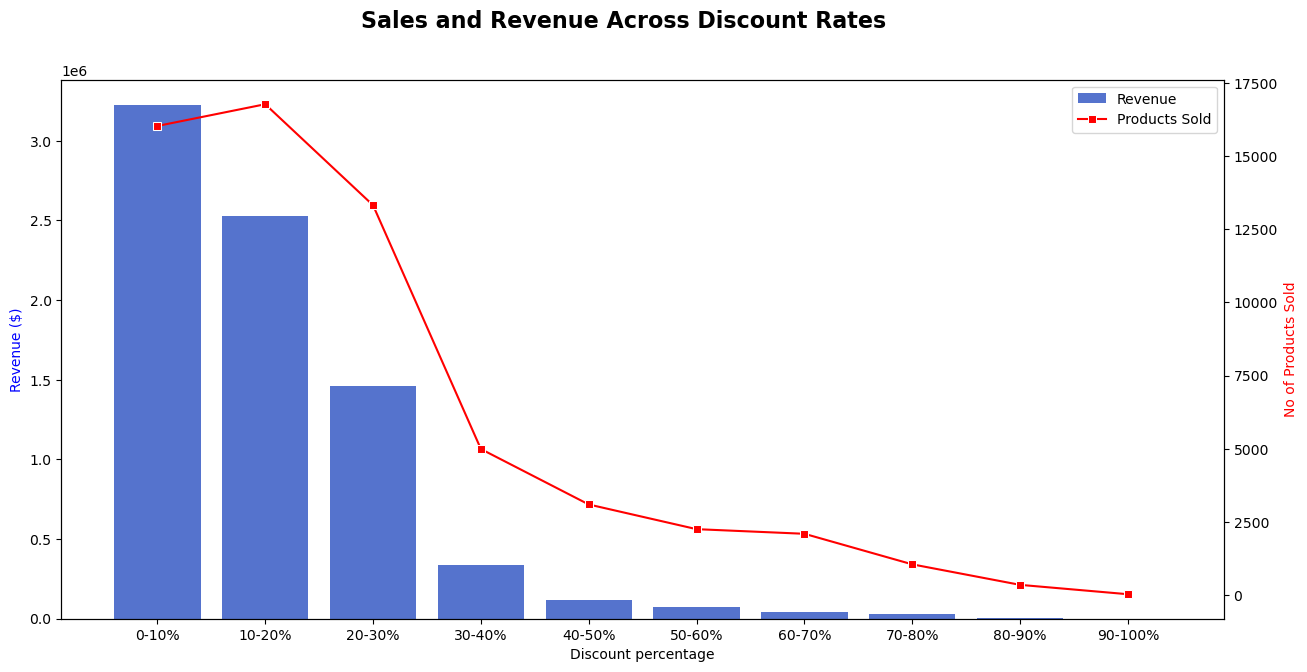

In [40]:
fig, ax1 = plt.subplots(figsize=(15,7))
ax1 = sns.barplot(data=orderlines_products_qu.groupby('discount_category').agg({'unit_price_total': 'sum'}),
                  x='discount_category', y='unit_price_total',
                color="royalblue", 
                label="Revenue", legend=False)
ax1.set_ylabel("Revenue ($)", color="blue")
ax1.tick_params(axis="y")
ax1.set_xlabel("Discount percentage")

ax2 = ax1.twinx()
ax2 = sns.lineplot(data=orderlines_products_qu.groupby('discount_category').agg({'product_quantity': 'sum'}),
             palette=["r"], label="Products Sold", marker='s', legend=False)
ax2.set_ylabel("No of Products Sold", color="red")
ax2.tick_params(axis="y")
ax2.set_xlabel("Discount percentage")

# Merge legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

fig.suptitle("Sales and Revenue Across Discount Rates", fontsize=16, fontweight="bold")

plt.show()